<a href="https://colab.research.google.com/github/Greg-Vincent0711/Learning-Pytorch/blob/main/02_NN_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Make classification data

import sklearn
from sklearn.datasets import make_circles

# make 1000 samples

n_samples = 1000

# create circles - X is features, y is label
samples,labels = make_circles(n_samples, noise=0.03, random_state=42)
len(samples)


1000

In [34]:
print(samples[:5])
print(labels[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [35]:
# making a dataframe

import pandas as pd
# toy dataset - small enough to experiment with, big enough to practice ML
# fundamentals
circles = pd.DataFrame({"X1" : samples[:, 0], "X2" : samples[:, 1], "label": labels},)
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


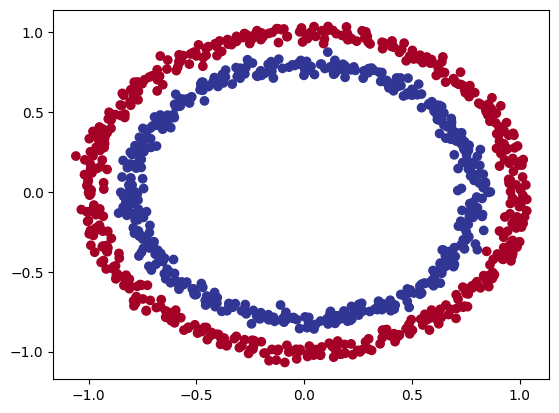

In [36]:
import matplotlib.pyplot as plt
plt.scatter(x=samples[:, 0], y=samples[:, 1], c=labels, cmap=plt.cm.RdYlBu)

In [37]:
samples.shape, labels.shape
samples

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [38]:
# view the first sample of feature and labels
X_sample = samples[0]
y_sample = labels[0]
X_sample, y_sample

(array([0.75424625, 0.23148074]), 1)

In [39]:
# turn data into tensors
import torch
samples = torch.from_numpy(samples).type(torch.float)
labels = torch.from_numpy(labels).type(torch.float)

# split the data into training/test sets
from sklearn.model_selection import train_test_split
# training data, testing data, training lables, testing lables
X_train, X_test, y_train, y_test = train_test_split(samples,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)


len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [40]:
# creating a model to classify blue and red dots

import torch
from torch import nn

# make device agonistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train.shape, y_train[:5]

(torch.Size([800, 2]), tensor([1., 0., 0., 0., 1.]))

In [41]:
# inherit from nn.Module
class CircleClassiferV1(nn.Module):
  def __init__(self):
    # initialize the nn.Module class first
      super().__init__()
      # create 2 nn.LinearLayers that can handle data shape
      # in_features -> size of each input sample.
      # we have 800 with a size of 2 each, so in_features is 2,
      self.layer_One = nn.Linear(in_features=2, out_features=5)
      # input into layer_two has to match with output from layer one
      # output from layer_two has to match with y's shape
      self.layer_Two = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    # actually connects the two layers
    return self.layer_Two(self.layer_One(x))


model_0 = CircleClassiferV1().to(device)



In [42]:
# remaking the model with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [43]:
# making initial predictions

with torch.inference_mode():
  init_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(init_preds)}, shape : {init_preds.shape}")
  print(f"\n First 10 preds: {init_preds[:10]}")
  print(f"\n First 10 labels: {y_test[:10]}")

Length of predictions: 200, shape : torch.Size([200, 1])

 First 10 preds: tensor([[-0.4439],
        [-0.2671],
        [-0.6573],
        [-0.3844],
        [-0.2603],
        [-0.1554],
        [ 0.0278],
        [ 0.0549],
        [-0.6737],
        [-0.2508]], device='cuda:0')

 First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [44]:
# setting up a loss fn and optimizer
loss = nn.BCEWithLogitsLoss() # uses Sigmoid Activation
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [45]:
def calculateAccuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [46]:
with torch.inference_mode():
  raw_logits = model_0(X_test.to(device))[:5]
# logit data needs to be in the same format as y_test
raw_logits, y_test[:5]

(tensor([[-0.4439],
         [-0.2671],
         [-0.6573],
         [-0.3844],
         [-0.2603]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [47]:
# pass to the sigmoid fn(typically used for bclassification)
y_pred_probabilities = torch.sigmoid(raw_logits)
# returns likeliness the model of point being a certain class
y_pred_probabilities

tensor([[0.3908],
        [0.4336],
        [0.3414],
        [0.4051],
        [0.4353]], device='cuda:0')

In [48]:
# compare pred probabilities labels to actual labels
y_prob_preds = torch.round(y_pred_probabilities)
# pretty poor since we haven't trained yet
y_prob_preds.squeeze(), y_train[:5]

(tensor([0., 0., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0., 1.]))

In [54]:
# actually training a BC model

torch.cuda.manual_seed(42)
epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward pass
  raw_logits = model_0(X_train).squeeze()
  # turn logits into prediction probabilities into lables
  y_preds = torch.round(torch.sigmoid(raw_logits))

  # BCEWithLogits expects logits over prediction probabilities
  training_loss = loss(raw_logits, y_train)

  training_accuracy = calculateAccuracy(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()
  # backpropagation
  training_loss.backward()
  # gradient descent
  optimizer.step()

  # testing loop
  model_0.eval()
  with torch.inference_mode():
    # remove an extra dimension and forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss(test_logits, y_test)
    test_accuracy = calculateAccuracy(y_true=y_test, y_pred=test_pred)


    if epoch % 10 == 0:
      print("since we have 500 samples of each, model is basically guessing")
      print(f'Epoch # {epoch} | Loss: {training_loss:.5f}, Train Acc: {training_accuracy:.2f}%,  Test Loss:{test_loss:.5f}, Test acc:{test_accuracy:.2f}%')

since we have 500 samples of each, model is basically guessing
Epoch # 0 | Loss: 0.69299, Train Acc: 51.00%,  Test Loss:0.69444, Test acc:46.50%
since we have 500 samples of each, model is basically guessing
Epoch # 10 | Loss: 0.69299, Train Acc: 50.88%,  Test Loss:0.69444, Test acc:46.50%
since we have 500 samples of each, model is basically guessing
Epoch # 20 | Loss: 0.69299, Train Acc: 50.50%,  Test Loss:0.69444, Test acc:46.50%
since we have 500 samples of each, model is basically guessing
Epoch # 30 | Loss: 0.69299, Train Acc: 50.88%,  Test Loss:0.69444, Test acc:46.50%
since we have 500 samples of each, model is basically guessing
Epoch # 40 | Loss: 0.69299, Train Acc: 51.00%,  Test Loss:0.69444, Test acc:46.00%
since we have 500 samples of each, model is basically guessing
Epoch # 50 | Loss: 0.69299, Train Acc: 50.88%,  Test Loss:0.69445, Test acc:46.00%
since we have 500 samples of each, model is basically guessing
Epoch # 60 | Loss: 0.69299, Train Acc: 50.88%,  Test Loss:0.69

In [59]:
# visualizing predictions, evaluating model
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Exists already")
else:
  print("Downloading helper fns")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

Exists already


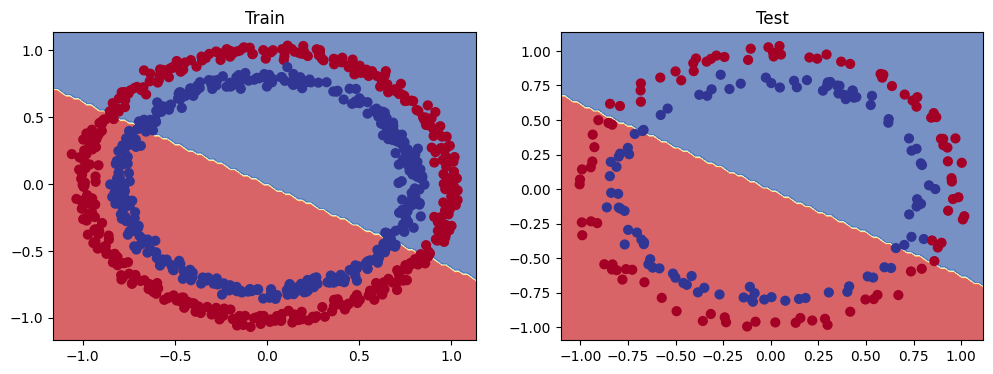

In [60]:
# plot decision boundary on model

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2 ,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)